In [ ]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, roc_curve, precision_recall_curve, auc

Graph Split Function

In [ ]:
def train_test_split_graph(G, train_frac=0.8, test_frac=0.1, seed=42):
    np.random.seed(seed)
    edges = list(G.edges())
    np.random.shuffle(edges)
    m = len(edges)
    n_train = int(train_frac * m)
    n_test = int(test_frac * m)

    train_edges = edges[:n_train]
    test_pos = edges[n_train:n_train + n_test]

    G_train = nx.Graph()
    G_train.add_nodes_from(G.nodes())
    G_train.add_edges_from(train_edges)

    non_edges = list(nx.non_edges(G_train))
    np.random.shuffle(non_edges)
    test_neg = non_edges[:n_test]

    return G_train, test_pos, test_neg

Scoring methods

In [ ]:
def score_method(G_train, u, v, method):
    if method == 'common_neighbors':
        return len(list(nx.common_neighbors(G_train, u, v)))
    if method == 'jaccard':
        return next(nx.jaccard_coefficient(G_train, [(u, v)]))[2]
    if method == 'adamic_adar':
        return next(nx.adamic_adar_index(G_train, [(u, v)]))[2]
    if method == 'pref_attachment':
        return next(nx.preferential_attachment(G_train, [(u, v)]))[2]
    if method == 'resource_allocation':
        return next(nx.resource_allocation_index(G_train, [(u, v)]))[2]
    raise ValueError(f"Unknown method {method}")

Method evaluation with detailed scores

In [ ]:
def evaluate_method(G_train, test_pos, test_neg, method):
    pairs = test_pos + test_neg
    y_true = np.array([1]*len(test_pos) + [0]*len(test_neg))
    scores = np.array([score_method(G_train, u, v, method) for u, v in pairs])

    # ROC AUC
    auc_score = roc_auc_score(y_true, scores)
    # ROC curve data
    fpr, tpr, _ = roc_curve(y_true, scores)

    # Precision-Recall AUC
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, scores)
    pr_auc = auc(recall_vals, precision_vals)

    # Precision@k
    k = len(test_pos)
    idx_top = np.argsort(scores)[::-1][:k]
    y_pred_top = np.zeros_like(y_true)
    y_pred_top[idx_top] = 1
    precision_k = precision_score(y_true, y_pred_top)

    return {
        'method': method,
        'AUC': auc_score,
        'PR_AUC': pr_auc,
        'Precision@k': precision_k,
        'fpr': fpr,
        'tpr': tpr,
        'precision_curve': precision_vals,
        'recall_curve': recall_vals
    }

Comparison across methods

In [ ]:
def compare_link_prediction(G, methods=None, train_frac=0.8, test_frac=0.1, seed=42):
    methods = methods or [
        'common_neighbors',
        'jaccard',
        'adamic_adar',
        'pref_attachment',
        'resource_allocation'
    ]
    G_train, test_pos, test_neg = train_test_split_graph(G, train_frac, test_frac, seed)
    detail = [evaluate_method(G_train, test_pos, test_neg, m) for m in methods]
    summary = pd.DataFrame([
        {
            'method': r['method'],
            'AUC': r['AUC'],
            'PR_AUC': r['PR_AUC'],
            'Precision@k': r['Precision@k']
        }
        for r in detail
    ])
    return summary, detail

Plotting functions

In [ ]:
def plot_roc_curves(detail_results):
    plt.figure(figsize=(8, 6))
    for res in detail_results:
        plt.plot(res['fpr'], res['tpr'], label=f"{res['method']} (AUC={res['AUC']:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_pr_curves(detail_results):
    plt.figure(figsize=(8, 6))
    for res in detail_results:
        plt.plot(res['recall_curve'], res['precision_curve'], label=f"{res['method']} (PR AUC={res['PR_AUC']:.2f})")
    plt.title('Precision-Recall Curves')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_metric_bars(df):
    df_plot = df.set_index('method')
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    df_plot['AUC'].plot(kind='bar', ax=axes[0], title='ROC AUC Comparison')
    axes[0].set_ylabel('AUC')
    df_plot['PR_AUC'].plot(kind='bar', ax=axes[1], title='PR AUC Comparison')
    axes[1].set_ylabel('PR AUC')
    df_plot['Precision@k'].plot(kind='bar', ax=axes[2], title='Precision@k Comparison')
    axes[2].set_ylabel('Precision@k')
    plt.tight_layout()
    plt.show()

Example usage


Summary Results:
                 method    AUC  PR_AUC  Precision@k
0     common_neighbors  0.653   0.730        0.571
1              jaccard  0.418   0.409        0.429
2          adamic_adar  0.704   0.803        0.571
3      pref_attachment  0.765   0.804        0.714
4  resource_allocation  0.704   0.803        0.571


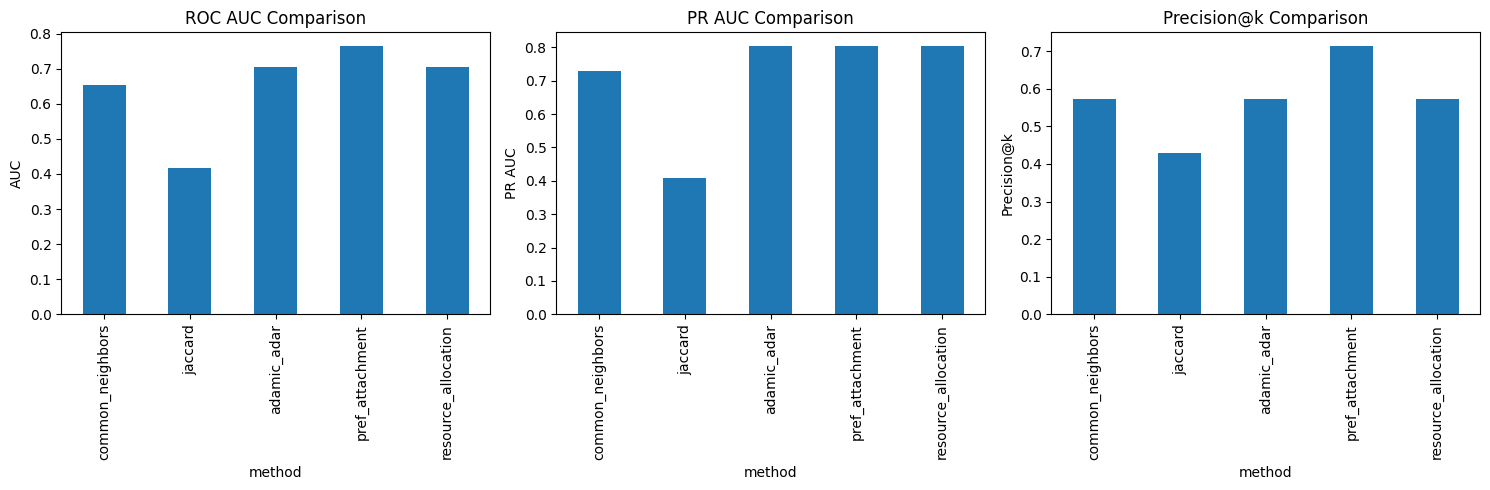

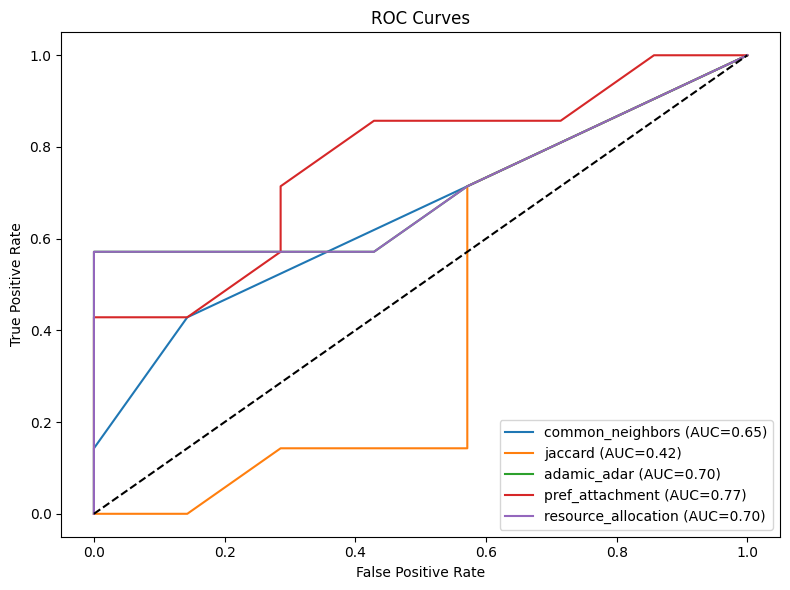

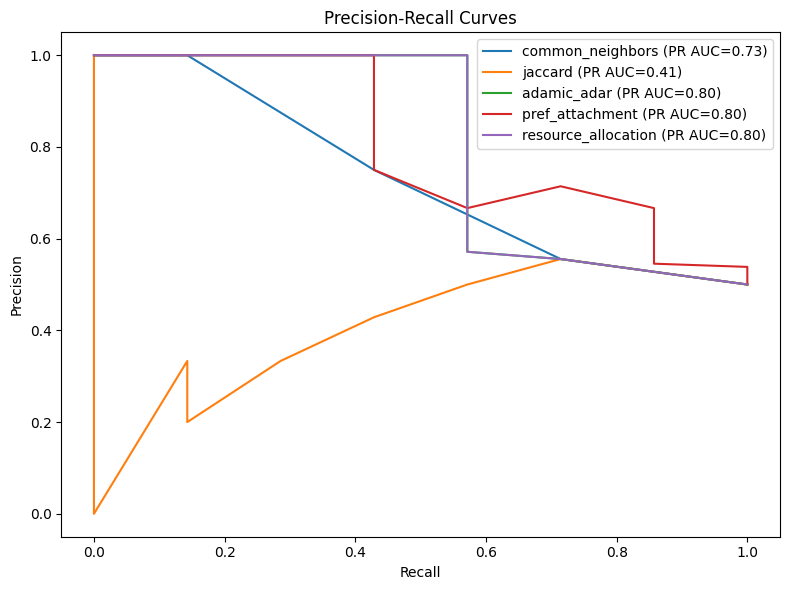


Summary Table:
             method      AUC   PR_AUC  Precision@k
   common_neighbors 0.653061 0.730159     0.571429
            jaccard 0.418367 0.408844     0.428571
        adamic_adar 0.704082 0.802721     0.571429
    pref_attachment 0.765306 0.804463     0.714286
resource_allocation 0.704082 0.802721     0.571429


In [ ]:
if __name__ == '__main__':
    G = nx.karate_club_graph()  # Replace with a larger real-world graph as needed
    summary_df, detail_results = compare_link_prediction(G)
    print("\nSummary Results:\n", summary_df.round(3))
    plot_metric_bars(summary_df)
    plot_roc_curves(detail_results)
    plot_pr_curves(detail_results)
    print("\nSummary Table:")
    print(summary_df.to_string(index=False))